# <center>Ensemble learning</center>

In [1]:
# імпортуємо усі необхідні для роботи модулі

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

To find the data, you can use link www.kaggle.com/rahulsah06/gooogle-stock-price

In [2]:
# завантажуємо csv-файли, у якому збережені дані

train_data = pd.read_csv('D:\Analysis/Google_Stock_Price_Train.csv')
test_data = pd.read_csv('D:\Analysis/Google_Stock_Price_Test.csv')

In [3]:
train_data

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


Хочу надати трохи пояснень щодо самих даних. 

"Google Stock Price" - набір даних фондового ринку, у якому розміщені ціни на акції.

<b><i>Open Price</i></b> - ціна відкриття(ціна, за якою цінний папір вперше торгується після відкриття біржі в торговий день)<br>
<b><i>Close Price</i></b> - ціна закриття(ціна цінного паперу до офіційного закриття ринку)<br>
<b><i>High Price</i></b> - найвища ціна на момент закриття акції.<br>
<b><i>Low Price</i></b> - найнижча ціна на момент закриття акції.<br>
<b><i>Volume</i></b> - обсяг акцій, що торгуються протягом дня.<br>

Завдання лабораторної роботи - прогноз ціни.
Логічно прогнозувати саме ціну закриття - Close Price.<br>
Я вирішила трохи дослідити, як взагалі пронозуються ціни фондового ринку, тому хочу розповісти з чим мені вдалось ознайомитись.
Їх доволі часто прогнозують за допомогою методів глибокого навчання, безспосередньо - застосуванням 
нейронних мереж. І для прогнозування дані про ціни на акції використовують дані у якості часових рядів.
Тому я вирішила скористатись таким методом.<br><br>
Але як отримати із наявного датасету часовий ряд?
Для цього нам знадобиться лише дані з колонки ціни закриття Close Price. <br>
Існує кілька способів реорганізації даних.<br>
 - Перший полягає в тому, що ми використовуємо для feature X попереднє значення ціни, а для цільової змінної у - поточне.<br>
 - Другий дуже схожий на попередній, тільки замість одного значення у feature X, ми використовуємо деяку послідовність попередніх значень ціни.<br><br>

<b><i>У своїй роботі я використала перший спосіб.</i></b>

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


In [5]:
train_data['Date'] = pd.to_datetime(train_data['Date'])

In [6]:
train_data['Close']= train_data['Close'].apply(lambda x : x.replace(',', '')).astype('float')

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 59.1+ KB


Порядок в даних наведений, можемо утворити часовий ряд, що знадобиться для подальшого прогнозу.

In [8]:
df_closing = train_data['Close'].to_frame()
df_closing['Y'] = df_closing['Close'].shift(-1)
df_closing = df_closing.dropna()  # останній рядок видаляємо, тому що використовується 
                                  # найостанніше значення в якості попереднього, якому у відповідність поставлене NaN значення

In [9]:
df_closing

,Close,Y
0,663.59,666.45
1,666.45,657.21
2,657.21,648.24
3,648.24,620.76
4,620.76,621.43
...,...,...
1252,791.26,789.91
1253,789.91,791.55
1254,791.55,785.05
1255,785.05,782.79


### 1. Візуалізація даних

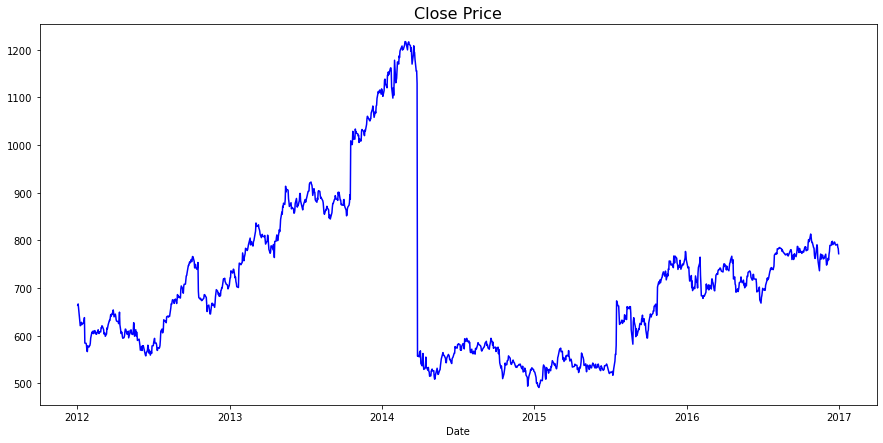

In [10]:
plt.figure(figsize=(15,7))
plt.plot(train_data['Date'], train_data.Close, color='blue')
plt.xlabel('Date')
plt.title('Close Price', fontsize=16)
plt.show()

### 2. Навчальний, перевірочний, тестовий набори даних

Зауважу, що тестовий набір даних завантажений csv-файлом. Лишилось відокремити навчальний та перевірочний набори.

In [11]:
X, y = df_closing.Close.values, df_closing.Y.values
X = X.reshape(-1,1)
y = y.reshape(-1,1)

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
df_closing_test = test_data.Close.to_frame()
df_closing_test['Y'] = df_closing_test.shift(-1)
df_closing_test = df_closing_test.dropna()
df_closing_test

,Close,Y
0,786.14,786.90
1,786.90,794.02
2,794.02,806.15
3,806.15,806.65
4,806.65,804.79
5,804.79,807.91
6,807.91,806.36
7,806.36,807.88
8,807.88,804.61
9,804.61,806.07


In [14]:
X_test, y_test = df_closing_test.Close.values, df_closing_test.Y.values
X_test = X_test.reshape(-1,1)
y_test = y_test.reshape(-1,1)

### 3.Побудова моделей

#### Індивідуальні моделі

Я вирішила взяти 4 індивідуальні моделі:
- Linear Regression;
- Ridge Regression;
- SVR;
- Decision Tree Regressor.

#### Linear Regression

In [56]:
start = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train)
end = time.time()

In [57]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, lr.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, lr.predict(X_train))))
print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, lr.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, lr.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9834279793093871
RMSE: 21.397626837875716

-----VALIDATION SET-----
R2-Score: 0.9962960311580003
RMSE: 9.75026144393638


#### Ridge Regression

In [17]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [18]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, ridge.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train))))
print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, ridge.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, ridge.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9834279793093856
RMSE: 21.39762683787665

-----VALIDATION SET-----
R2-Score: 0.9962960305984329
RMSE: 9.750262180433944


#### SVR

In [19]:
svr = SVR()
svr.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR()

In [20]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, svr.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, svr.predict(X_train))))
print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, svr.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, svr.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.6683890235310463
RMSE: 95.7177154937761

-----VALIDATION SET-----
R2-Score: 0.6889028172805606
RMSE: 89.35742345490235


#### Decision Tree Regression

In [21]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [22]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, tree.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, tree.predict(X_train))))
print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, tree.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, tree.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.999976528130175
RMSE: 0.8052889130899842

-----VALIDATION SET-----
R2-Score: 0.9480337570244138
RMSE: 36.521050272628706


Отже, побудовано 4 індивідуальні моделі. Серед них найкраще працюють перші дві - Linear i Ridge Regression;
Модель DecisionTreeRegression призвела до перенавчання.
Тому вважаю, що ансамблі моделей варто побудувати лише для виділених моделей.

### Ансамблі моделей 

#### Ансамбль моделей(Linear Regression)

In [23]:
from sklearn.ensemble import AdaBoostRegressor

abr_def = AdaBoostRegressor(random_state=0, n_estimators=100)
abr_def.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(n_estimators=100, random_state=0)

In [24]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_def.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_def.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_def.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_def.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9887221769952315
RMSE: 17.651861580261166

-----VALIDATION SET-----
R2-Score: 0.9453389966566382
RMSE: 37.45600016816491


In [25]:
abr_lr = AdaBoostRegressor(base_estimator=lr)
abr_lr.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression())

In [26]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_lr.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_lr.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_lr.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_lr.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.983366183082697
RMSE: 21.437485049067746

-----VALIDATION SET-----
R2-Score: 0.996342492896333
RMSE: 9.68891593563699


In [27]:
abr_ridge = AdaBoostRegressor(base_estimator=ridge)
abr_ridge.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=Ridge())

In [28]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_ridge.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_ridge.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_ridge.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_ridge.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9834174323421716
RMSE: 21.404434823964692

-----VALIDATION SET-----
R2-Score: 0.9962465970443388
RMSE: 9.815110527065848


Побудуємо ще кілька альтернативних ансамблів, розглянувши різні значення параметрів.

In [29]:
abr_2 = AdaBoostRegressor(base_estimator = lr, n_estimators = 500)
abr_2.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=500)

In [30]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_2.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_2.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_2.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_2.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9832808655794889
RMSE: 21.492392873444942

-----VALIDATION SET-----
R2-Score: 0.9959954425205575
RMSE: 10.138176891168913


In [31]:
abr_3 = AdaBoostRegressor(base_estimator = lr, n_estimators = 30)
abr_3.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=30)

In [32]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_3.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_3.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_3.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_3.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9832209906812842
RMSE: 21.53084297301284

-----VALIDATION SET-----
R2-Score: 0.9958808151282968
RMSE: 10.282251932193006


In [33]:
abr_4 = AdaBoostRegressor(base_estimator = lr, n_estimators = 30, loss='exponential')
abr_4.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(), loss='exponential',
                  n_estimators=30)

In [34]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_4.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_4.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_4.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_4.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9716813559759967
RMSE: 27.971393512761733

-----VALIDATION SET-----
R2-Score: 0.9826760235286136
RMSE: 21.086591818050458


In [35]:
abr_5 = AdaBoostRegressor(base_estimator = lr, n_estimators = 200, loss='square')
abr_5.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(), loss='square',
                  n_estimators=200)

In [36]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_5.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_5.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_5.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_5.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9834271101247558
RMSE: 21.398187971755497

-----VALIDATION SET-----
R2-Score: 0.9962823564911556
RMSE: 9.76824333682583


In [37]:
abr_6 = AdaBoostRegressor(base_estimator = lr, n_estimators = 200, learning_rate=0.1)
abr_6.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(), learning_rate=0.1,
                  n_estimators=200)

In [38]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_6.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_6.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_6.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_6.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9656972204748663
RMSE: 30.785239170238857

-----VALIDATION SET-----
R2-Score: 0.9761644573511072
RMSE: 24.734043515990127


In [39]:
abr_7 = AdaBoostRegressor(base_estimator = lr, n_estimators = 300, learning_rate=3, loss='square')
abr_7.fit(X_train, y_train)

D:\anaconda\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(base_estimator=LinearRegression(), learning_rate=3,
                  loss='square', n_estimators=300)

In [40]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_7.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_7.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_7.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_7.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9827852868749188
RMSE: 21.808599190261646

-----VALIDATION SET-----
R2-Score: 0.9959950027951535
RMSE: 10.138733493437568


Ми розглянули різні альтернативні моделі, вказуючи різні значення для наведених параметрів.
Варто виконати решітчастий пошук для відшукання найкращих значень параметрів.<br>
Але для початку створимо графік залежності значень показника якості ансамбля та індивідуальної моделі від n_estimators.

### Графік залежності ансамбля та індивідуальної моделі від n_estimators

In [62]:
import warnings
warnings.filterwarnings("ignore")

dct = {}
for i in range(10,301,5):
    model = AdaBoostRegressor(base_estimator=lr, n_estimators=i)
    model.fit(X_train, y_train)
    dct[i] = r2_score(y_train, model.predict(X_train))

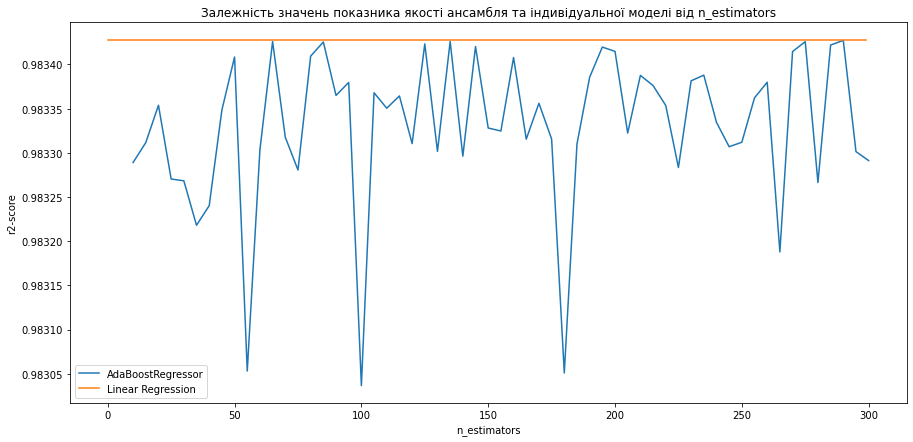

In [63]:
plt.figure(figsize=(15,7))
plt.plot(dct.keys(), dct.values(), label='AdaBoostRegressor')
plt.plot([r2_score(y_train, lr.predict(X_train)) for i in range(300)], label='Linear Regression')
plt.legend(loc='best')
plt.xlabel('n_estimators')
plt.ylabel('r2-score')
plt.title('Залежність значень показника якості ансамбля та індивідуальної моделі від n_estimators')
plt.show()

In [64]:
# знайдемо значення, для якого досягається найбільше значення r2-score:
a = [i for i  in dct.keys() if round(dct[i], 4) ==0.9834 and i < 100]
print('Needed value:', min(a))

Needed value: 20


In [65]:
abr_8 = AdaBoostRegressor(base_estimator=lr, n_estimators=20)
abr_8.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=LinearRegression(), n_estimators=20)

In [66]:
print('-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_8.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_8.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_8.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_8.predict(X_valid))))

-----TRAINING SET-----
R2-Score: 0.9833874331069778
RMSE: 21.42378727105179

-----VALIDATION SET-----
R2-Score: 0.9963373865864554
RMSE: 9.695677009463482


### Решітчастий пошук

In [69]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':[20, 30, 50, 75, 100],
              'learning_rate':[0.5, 1, 2, 5, 10],
              'loss':['linear', 'square', 'exponential']}

abr_gs = GridSearchCV(abr_8, parameters, scoring='r2')
abr_gs.fit(X_valid,y_valid)

GridSearchCV(estimator=AdaBoostRegressor(base_estimator=LinearRegression(),
                                         n_estimators=20),
             param_grid={'learning_rate': [0.5, 1, 2, 5, 10],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [20, 30, 50, 75, 100]},
             scoring='r2')

In [70]:
print("Best parameters:",abr_gs.best_params_)

Best parameters: {'learning_rate': 2, 'loss': 'linear', 'n_estimators': 30}


In [71]:
start_2 = time.time()
abr_best = AdaBoostRegressor(base_estimator=lr, n_estimators=30, learning_rate=2, loss='linear')
abr_best.fit(X_valid, y_valid)
end_time = time.time()

In [72]:
print('\n-----TRAINING SET-----')
print("R2-Score:",r2_score(y_train, abr_best.predict(X_train)))
print("RMSE:", np.sqrt(mean_squared_error(y_train, abr_best.predict(X_train))))

print('\n-----VALIDATION SET-----')
print("R2-Score:",r2_score(y_valid, abr_best.predict(X_valid)))
print("RMSE:", np.sqrt(mean_squared_error(y_valid, abr_best.predict(X_valid))))

print('-----TEST SET-----')
print("R2-Score:",r2_score(y_test, abr_best.predict(X_test)))
print("RMSE:", np.sqrt(mean_squared_error(y_test, abr_best.predict(X_test))))


-----TRAINING SET-----
R2-Score: 0.9833886917116246
RMSE: 21.4229756990317

-----VALIDATION SET-----
R2-Score: 0.996346573863038
RMSE: 9.683509086397253
-----TEST SET-----
R2-Score: 0.5793579826070815
RMSE: 7.897192936755922


Ансамбль моделі я виконувала на базі саме лінійної регресії LinearRegression(), адже вона разом із Rіdge Regression давала
майже однакові результати.
Отже, ми виконали решітчастий пошук і побудували найкращу модель ансамбля.

### Трохи візуалiзації

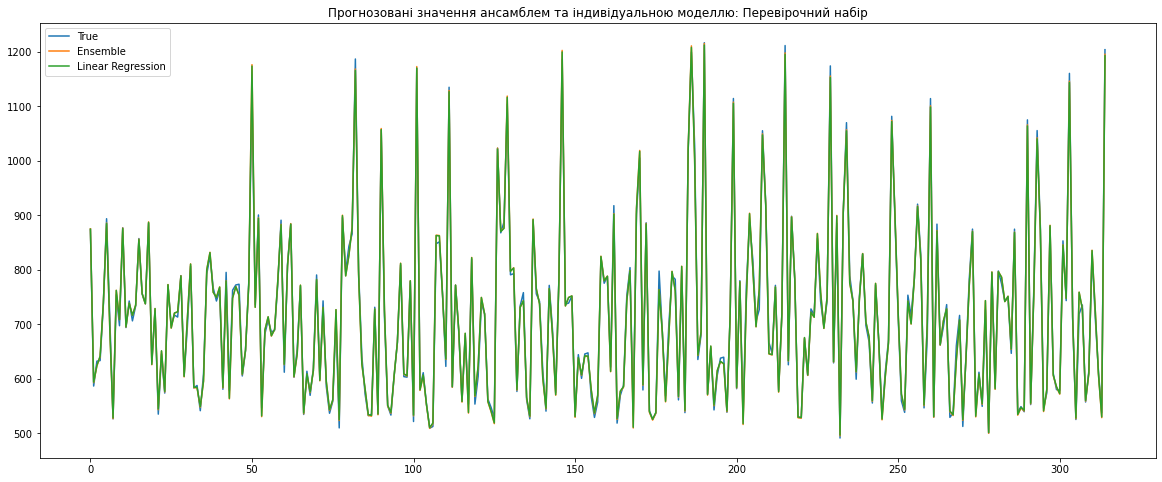

In [73]:
plt.figure(figsize=(20,8))
plt.plot(y_valid, label='True')
plt.plot(abr_best.predict(X_valid), label='Ensemble')
plt.plot(lr.predict(X_valid), label='Linear Regression')
plt.legend(loc='best')
plt.title('Прогнозовані значення ансамблем та індивідуальною моделлю: Перевірочний набір')
plt.show()

Трохи збільшимо масштаб графіка

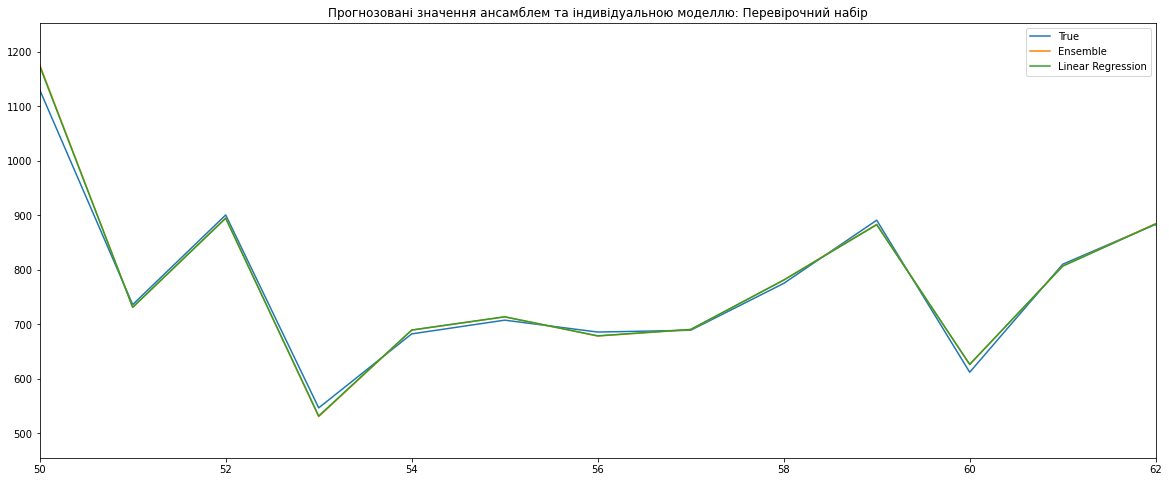

In [74]:
plt.figure(figsize=(20,8))
plt.plot(y_valid, label='True')
plt.plot(abr_best.predict(X_valid), label='Ensemble')
plt.plot(lr.predict(X_valid), label='Linear Regression')
plt.legend(loc='best')
plt.xlim(50,62)
plt.title('Прогнозовані значення ансамблем та індивідуальною моделлю: Перевірочний набір')
plt.show()

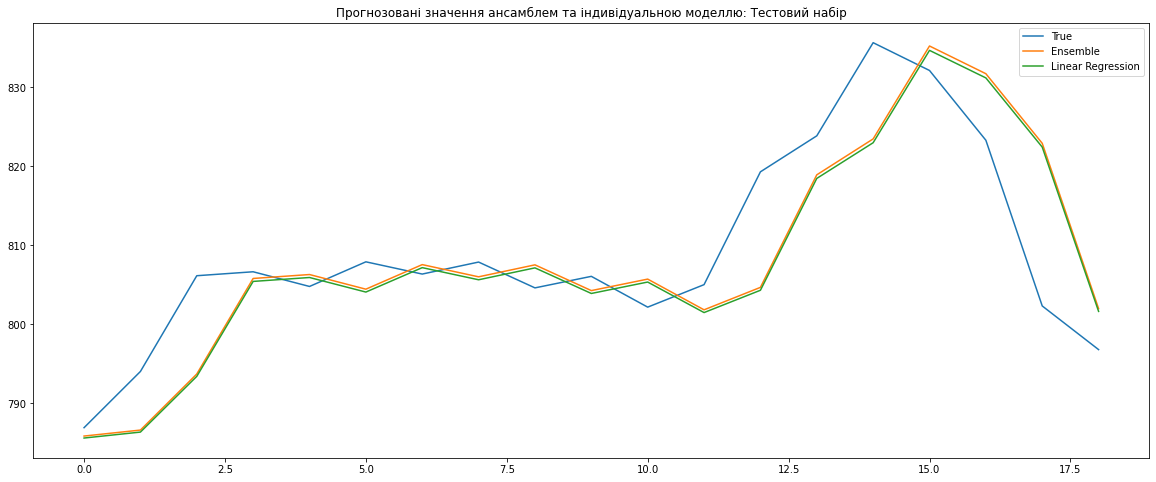

In [75]:
plt.figure(figsize=(20,8))
plt.plot(y_test, label='True')
plt.plot(abr_best.predict(X_test), label='Ensemble')
plt.plot(lr.predict(X_test), label='Linear Regression')
plt.legend(loc='best')
plt.title('Прогнозовані значення ансамблем та індивідуальною моделлю: Тестовий набір')
plt.show()

In [76]:
print("Час на навчання індивідуальної моделі:",
      (end-start), "секунд.")
print("Час на навчання ансамбля:",
      (end_time-start_2), "секунд.")

Час на навчання індивідуальної моделі: 0.001995086669921875 секунд.
Час на навчання ансамбля: 0.011106729507446289 секунд.


Як ми можемо помітити, <b><i>ансамбль моделей навчався довше за індивідуальну модель.</i></b>
Тому це може зіграти сильну роль на більш великих наборах даних.

### Висновки

По-перше, як ми можемо помітити, суттєвих покращень у сторону якості ансамбля для поточного набору даних не виявлено. 
Так, ансамбль ,дійсно, трохи краще впорався на валідаційному та тестовому наборах.<br>
По-друге, відомо, що одним із недоліків бустингу є схильність до перенавчання. Якраз це можемо помітити на тестовому наборі,
де значення метрик якості доволі нижчі.<br>
Я вважаю, що для заданого набору даних, власне для прогнозування ціни, ми могли скористатись лише індивідуальною моделлю і
її результати теж доволі задовільні.

### Додаткова інформація

Як я вже зазначала, реорганізація нашого набору даних у часовий ряд - не єдиний спосіб прогнозування цін на акції.
Взагалі, можна було діяти "стандартним" способом: виконати первинний дослідницький аналіз, уважно ознайомившись із 
залежними змінними та цільовою змінною.
Зараз я спробую побудувати кореляційну матрицю на основі набору даних.

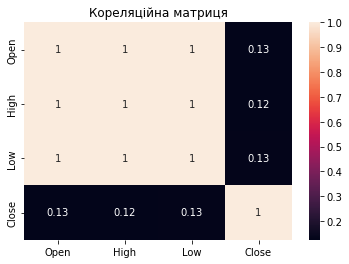

In [55]:
corr = train_data.corr()
sns.heatmap(corr, annot=True)
plt.title('Кореляційна матриця')
plt.show()

Якщо Close - цільова змінна, то ми бачимо, що фічі Open, High, Low є сильно корельованими, а тому, без сумніву, що
між ними спостерігається своєрідна залежність, хоча, це цілком логічно.
Ми спостерігаємо явище <b><i>мультиколінеарності</i></b>.<br>
Є кілька способів прогнозування даних, у яких спостерігається мультиколінеарність:
- викинути з набору деякі змінні, що між собою корельовані;
- розглянути Ridge чи Lasso Regression;<br>

Також я побачила один із методів, де замість заданих фічей Open, High i Low, використовувались Open-High, High-Low фічі,
кожна з яких означала різницю між двома цінами. Тоді перерахувавши кореляційн матрицю, можна було побачити, що вже не існує
сильної кореляції між фічами і далі займатись прогнозуванням.<br>
Насправді, це доволі нелегко, але не менш цікаво.<br>
Тому я скористалась більш оптимальним, на мою думку, шляхом.